In [11]:
# Download the relevant modules:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from numba import njit, jit

In [12]:
# Generate the corresponding Dataset:

# Generate the mesh grid for the neural network
num_i_grid_points = 500
num_j_grid_points = 500
Final_Time = 20.0
num_timesteps = 500
num_grid_points = num_i_grid_points * num_j_grid_points
Length = 100.0

dx = (Length)/(num_i_grid_points)
dy = (Length)/(num_j_grid_points)
X = np.linspace(0, Length, num_i_grid_points, dtype = np.float64)
y = np.linspace(0, Length, num_j_grid_points, dtype = np.float64)
Time = np.linspace(0, Final_Time, num_timesteps, dtype = np.float64)

def Generate_Dataset(Dataset_Size):
    index = 0
    Dataset = []
    while index <= Dataset_Size -1:
        timestep = np.random.uniform(low = 0, high = Final_Time, size = (1))
        x_position = np.random.uniform(low = 0, high = Length, size = (1))
        y_position = np.random.uniform(low = 0, high = Length, size = (1))
        Dataset.append([timestep, x_position, y_position])
        index+=1
    return np.array(Dataset, dtype = np.float32)   

Dataset_Size = 100000
Dataset = Generate_Dataset(Dataset_Size).reshape(-1,3)
Dataset.shape 

(100000, 3)

In [36]:
# Set up the remaining Parameters
Train_Dataset, Validation_Dataset = train_test_split(Dataset,test_size = 0.4, random_state = 42)
print(Train_Dataset.shape), print(Validation_Dataset.shape)

l1, l2 = [],[]
batch_size = 257
for index, element in enumerate(list(Train_Dataset)):
    if index % batch_size !=0:
        l1.append(list(element))
    elif index % batch_size == 0 and index !=0:
        print(len(l1))
        l2.append(l1)
        l1 = []
Mini_Batch_Train_Dataset = np.array(l2)

l1, l2 = [],[]
batch_size = 257
for index, element in enumerate(list(Validation_Dataset)):
    if index % batch_size !=0:
        l1.append(list(element))
    elif index % batch_size == 0 and index !=0:
        print(len(l1))
        l2.append(l1)
        l1 = []
Mini_Batch_Valid_Dataset = np.array(l2)

# Generate the Neural Network and Optimizer Parameters:
activation_func = "gelu"
batch_size = 257
kernel_initializer = "he_normal"
kernel_regularizer = "l1_l2"
learning_rate = 1e-3
use_ema = True
beta_1 = 0.9, 
beta_2 = 0.999, 
weight_decay = 0.004
Layers = [64,64,64,64,64,64]
num_features = 3
dropout_rate = 0.1
num_outputs = 1
groups = 32

Mini_Batch_Train_Dataset.shape, Mini_Batch_Valid_Dataset.shape

(60000, 3)
(40000, 3)
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
25

((233, 256, 3), (155, 256, 3))

In [37]:
def PINN(layers, num_features, dropout_rate, activation_func, kernel_initializer, num_outputs, kernel_regularizer, groups):
    Inputs = tf.keras.layers.Input(shape = (num_features,))
    outputs = tf.keras.layers.LayerNormalization()(Inputs)
    
    index = 0
    for unit in layers:
        if index != 0:
            x = outputs
        outputs = tf.keras.layers.Dense(units = unit, activation = activation_func)(outputs)
        outputs = tf.keras.layers.Dense(units = unit, activation = activation_func)(outputs)
        outputs = tf.keras.layers.LayerNormalization()(outputs)
        if index != 0:
            outputs = tf.keras.layers.Add()([x, outputs])
        index +=1
    
    output = tf.keras.layers.Dense(num_outputs, activation  = "linear")(outputs)

    Model = tf.keras.Model(inputs = Inputs, outputs = output)
    return Model

# Define the neural network
Model = PINN(Layers, num_features, dropout_rate, activation_func, kernel_initializer, num_outputs, kernel_regularizer, groups)
Model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 layer_normalization_21 (La  (None, 3)                    6         ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 dense_39 (Dense)            (None, 64)                   256       ['layer_normalization_21[0][0]
                                                                    ']                            
                                                                                            

In [41]:
@tf.function
def train_step(x,y,t, initial_temps, Heat_Source, alpha = tf.constant(np.pi)):
        
        batch_size = x.shape[0]
        zeros = tf.zeros((batch_size,), dtype = tf.float32)
        Heat = Heat_Source * tf.ones((batch_size,), dtype= tf.float32)
        N_n1 = Length*tf.ones((batch_size,), dtype = tf.float32)
     
        with tf.GradientTape(persistent=True) as tape:

                with tf.GradientTape(persistent=True) as tape2:
                        tape2.watch(x)
                        tape2.watch(y)
                        tape2.watch(t)

                        with tf.GradientTape(persistent=True) as tape1:
                                tape1.watch(x)
                                tape1.watch(y)
                                tape1.watch(t)

                                # Run the model to get the temperature prediction at points (x,y, t):
                                T = Model(tf.stack([x, y, t], axis=-1))
                                T_0t = Model(tf.stack([x,y,zeros], axis = -1))

                                T_0x = Model(tf.stack([zeros,y,t], axis = -1))
                                T_0y = Model(tf.stack([x,zeros,t], axis = -1))

                                T_Nn1x = Model(tf.stack([N_n1,y,t], axis = -1))
                                T_Nn1y = Model(tf.stack([x,N_n1,t], axis = -1))

                                # Compute the first order derivatives
                                dT_dx = tape1.gradient(T, x)
                                dT_dy = tape1.gradient(T, y)
                                dT_dt = tape1.gradient(T, t)

                        # Compute the second order derivatives using the outer tape
                        dT2_dx2 = tape2.gradient(dT_dx, x)
                        dT2_dy2 = tape2.gradient(dT_dy, y)
        
                Loss_PDE_Components = tf.square((dT_dt - alpha*(dT2_dx2*dT2_dy2)))
                Loss_PDE = tf.reduce_mean(Loss_PDE_Components)
        
                # Compute the Initial Condition_Loss:
                Loss_IC_Components = tf.square(initial_temps - T_0t)
                Loss_IC = tf.reduce_mean(Loss_IC_Components)
        
                # Compute the Boundary Conditions:
                Loss_BC_Components_1 = tf.square(Heat - T_0x)
                Loss_BC_Components_2 = tf.square(0.0 - T_Nn1x)
                Loss_BC_Components_3 = tf.square(0.0 - T_0y)
                Loss_BC_Components_4 = tf.square(0.0 - T_Nn1y)

                Loss_BC = tf.reduce_mean(Loss_BC_Components_1) + tf.reduce_mean(Loss_BC_Components_2) + \
                          tf.reduce_mean(Loss_BC_Components_3) + tf.reduce_mean(Loss_BC_Components_4)
                
                # Compute the Loss Function:
                Train_Loss = Loss_PDE + Loss_IC + Loss_BC
                
                print(Loss_PDE, Loss_IC, Loss_BC)

                # Computes the gradients
                gradients = tape.gradient(Train_Loss, Model.trainable_variables)
        
                optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
        
        return Train_Loss
@tf.function
def test_step(x,y,t, initial_temps, Heat_Source, alpha = tf.constant(np.pi)):
        
        batch_size = x.shape[0]
        zeros = tf.zeros((batch_size,), dtype = tf.float32)
        Heat = Heat_Source * tf.ones((batch_size,), dtype= tf.float32)
        N_n1 = Length*tf.ones((batch_size,), dtype = tf.float32)

        with tf.GradientTape(persistent=True) as tape2:
                
                tape2.watch(x)
                tape2.watch(y)
                tape2.watch(t)
                with tf.GradientTape(persistent=True) as tape1:
                    
                    tape1.watch(x)
                    tape1.watch(y)
                    tape1.watch(t)

                    # Run the model to get the temperature prediction at points (x,y, t):
                    T = Model(tf.stack([x, y, t], axis=-1))
                    T_0t = Model(tf.stack([x,y,zeros], axis = -1))

                    T_0x = Model(tf.stack([zeros,y,t], axis = -1))
                    T_0y = Model(tf.stack([x,zeros,t], axis = -1))
        
                    T_Nn1x = Model(tf.stack([N_n1,x,y], axis = -1))
                    T_Nn1y = Model(tf.stack([x,N_n1,t], axis = -1))
                    
                    # Compute the first order derivatives
                    dT_dx = tape1.gradient(T, x)
                    dT_dy = tape1.gradient(T, y)
                    dT_dt = tape1.gradient(T, t)
                    
            # Compute the second order derivatives using the outer tape
                dT2_dx2 = tape2.gradient(dT_dx, x)
                dT2_dy2 = tape2.gradient(dT_dy, y)
        
        Loss_PDE_Components = tf.square((dT_dt - alpha*(dT2_dx2*dT2_dy2)))
        Loss_PDE = tf.reduce_mean(Loss_PDE_Components)
        
        # Compute the Initial Condition_Loss:
        Loss_IC_Components = tf.square(initial_temps - T_0t)
        Loss_IC = tf.reduce_mean(Loss_IC_Components)
        
        # Compute the Boundary Conditions:
        Loss_BC_Components_1 = tf.square(Heat - T_0x)
        Loss_BC_Components_2 = tf.square(0.0 - T_Nn1x)
        Loss_BC_Components_3 = tf.square(0.0 - T_0y)
        Loss_BC_Components_4 = tf.square(0.0 - T_Nn1y)

        Loss_BC = tf.reduce_mean(Loss_BC_Components_1) + tf.reduce_mean(Loss_BC_Components_2) + \
                tf.reduce_mean(Loss_BC_Components_3) + tf.reduce_mean(Loss_BC_Components_4)
                
        # Compute the Loss Function:
        Test_Loss = alpha*Loss_PDE + Loss_BC + Loss_IC
        
        return Test_Loss

In [42]:
# Custom Training Loop:
import time
Epochs = 100
Threshold = 0.5
best = np.inf
patience_1 = 15
wait_1 = 0
patience_2 = 8
wait_2 = 0
learning_rate_previous = learning_rate
# Apply gradients to update the model using an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
for epoch in range(Epochs):
    Train_Losses, Test_Losses = [], []
    print(f"Starting Epoch {epoch}")
    start_time = time.time()

    # Run through the training batches in the data:
    for step, x_mini_batch in enumerate(Mini_Batch_Train_Dataset):
        x,y,t, initial_temps, Heat = x_mini_batch[:,0], x_mini_batch[:,1], x_mini_batch[:,2], tf.zeros((batch_size,)), 1
        Train_Loss = train_step(x,y,t, initial_temps, Heat)
        
        if step % 100 == 0:
            print(f"Training Loss at {step} is {round(float(Train_Loss),5)}")

        Train_Losses.append(Train_Loss)

    Avg_Train_Loss = np.median(np.array(Train_Losses))
    # Run through the validaiton batches in the data:
    for step, x_mini_batch in enumerate(Mini_Batch_Valid_Dataset):
        x,y,t, initial_temps, Heat = x_mini_batch[:,0], x_mini_batch[:,1], x_mini_batch[:,2], tf.zeros((batch_size,)), 1
        Test_Loss = test_step(x,y,t, initial_temps, Heat)
        
        if step % 100 == 0:
            print(f"Test Loss at {step} is {round(float(Test_Loss),5)}")

        Test_Losses.append(Train_Loss)

    Avg_Test_Loss = np.median(np.array(Test_Losses))
    if best >= Avg_Test_Loss:
        best = Avg_Test_Loss

    wait_1 += 1
    if Avg_Test_Loss < best:
      best = Avg_Test_Loss
      wait_1 = 0
    if wait_1 >= patience_1:
      break

    wait_2 += 1
    if Avg_Test_Loss < best:
      best = Avg_Test_Loss
      wait_2 = 0
    if wait_2 >= patience_2:
      new_learning_rate = 0.5 * learning_rate_previous
      optimizer.learning_rate.assign(new_learning_rate)
      learning_rate_previous = new_learning_rate

    print(f"The Average Training Loss for this Epoch is {np.round(Avg_Train_Loss,3)}")
    print(f"The Average Validation Loss for this Epoch is {np.round(Avg_Test_Loss,3)}")
    print(f"Time taken for epoch to complete, {np.round(time.time() - start_time,2)}s")

Starting Epoch 0
Tensor("Mean:0", shape=(), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)
Training Loss at 0 is 28.63855
Training Loss at 100 is 4.8776
Training Loss at 200 is 30.60359
Test Loss at 0 is 24.09697
Test Loss at 100 is 20.45784
The Average Training Loss for this Epoch is 18.5939998626709
The Average Validation Loss for this Epoch is 20.54199981689453
Time taken for epoch to complete, 62.88s
Starting Epoch 1
Training Loss at 0 is 19.79947
Training Loss at 100 is 18.79621
Training Loss at 200 is 18.71325
Test Loss at 0 is 59.2937
Test Loss at 100 is 32.31142
The Average Training Loss for this Epoch is 21.854999542236328
The Average Validation Loss for this Epoch is 33.18899917602539
Time taken for epoch to complete, 24.12s
Starting Epoch 2
Training Loss at 0 is 33.22705
Training Loss at 100 is

In [40]:
Space_time_1 = np.stack([Train_Dataset[:,0], Train_Dataset[:,1], Train_Dataset[:,-2]] ,axis = -1)

In [85]:
Space_time_1.shape

(60000, 3)

1875/1875 [==============================] - 4s 2ms/step


(array([6.0250e+03, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 5.0000e+00, 5.3965e+04]),
 array([-3.88786626, -3.2691102 , -2.65035415, -2.03159785, -1.4128418 ,
        -0.79408574, -0.17532964,  0.44342646,  1.06218255,  1.68093872,
         2.29969478]),
 <BarContainer object of 10 artists>)

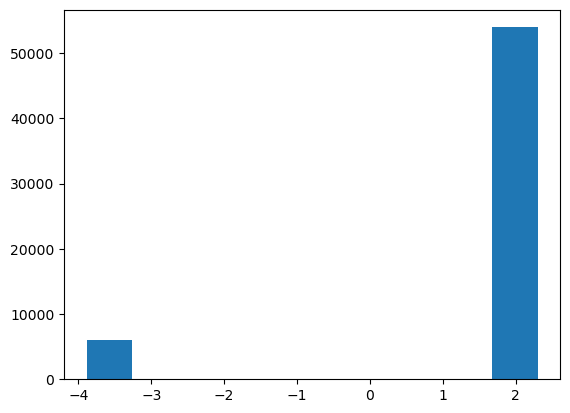

In [23]:
Predictions = Model.predict(Space_time_1)
Predictions.shape
plt.hist(Predictions)

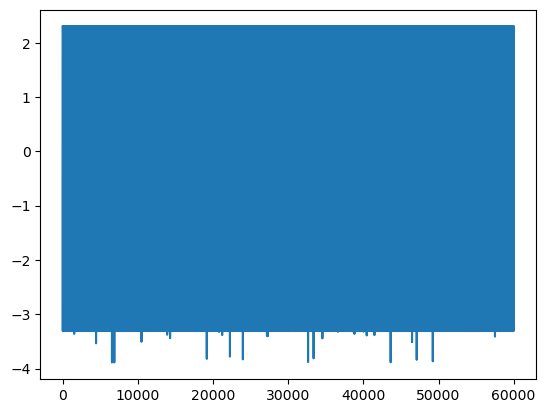

In [24]:
plt.plot(Predictions)

In [25]:
Theta_1 = np.linspace(0, 2*np.pi, 50, dtype = np.float64)
Zeta_1 = np.linspace(0, 2*np.pi, 50, dtype = np.float64)
Time_2 = np.linspace(0, Final_Time, num_timesteps, dtype = np.float64)

position_x, position_y = np.meshgrid(Theta_1, Zeta_1)
Temperature = np.zeros((50,50))
for index_i in range(len(position_x)):
    for index_j in range(len(position_y)):
        
        Temperature[index_i, index_j] = Model.predict(np.array([Theta_1[index_i], Zeta_1[index_j], 5.0]).reshape(-1,3))

1/1 [==============================] - ETA: 0s

C:\Users\kdarn\AppData\Local\Temp\ipykernel_5412\3418068655.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Temperature[index_i, index_j] = Model.predict(np.array([Theta_1[index_i], Zeta_1[index_j], 5.0]).reshape(-1,3))


1/1 [==============================] - 0s 16ms/step


In [26]:
Temperature

array([[-1.67555261, -1.65404975, -1.62507677, ...,  2.69232464,
         2.72228551,  2.74947524],
       [-1.69437981, -1.67555487, -1.65340459, ...,  2.69888353,
         2.72897029,  2.75621128],
       [-1.71464288, -1.69488382, -1.67555678, ...,  2.70565319,
         2.73585105,  2.76312709],
       ...,
       [-3.09095025, -3.09349871, -3.09614635, ...,  0.45624948,
         0.9010725 ,  1.22246218],
       [-3.1027329 , -3.10541391, -3.10819578, ..., -1.48911369,
         0.45675415,  0.8619144 ],
       [-3.11376309, -3.11654711, -3.11942768, ..., -2.34332561,
        -1.26995885,  0.4571147 ]])

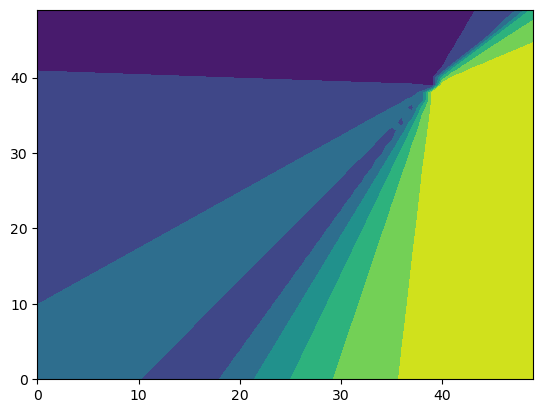

In [27]:
plt.contourf(Temperature)

In [ ]:
surf = ax.plot_surface()

In [250]:
Theta_1 = np.linspace(0, 2*np.pi, 50, dtype = np.float64)
Zeta_1 = np.linspace(0, 2*np.pi, 50, dtype = np.float64)
Time_2 = np.linspace(0, Final_Time, num_timesteps, dtype = np.float64)

position_x, position_y = np.meshgrid(Theta_1, Zeta_1)
Temperature = np.zeros((50,50))
for index_i in range(len(position_x)):
    for index_j in range(len(position_y)):
        
        Temperature[index_i, index_j] = Model.predict(np.array([Theta_1[index_i], Zeta_1[index_j], 1.0]).reshape(-1,3))

1/1 [==============================] - ETA: 0s

C:\Users\kdarn\AppData\Local\Temp\ipykernel_27748\1719173201.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Temperature[index_i, index_j] = Model.predict(np.array([Theta_1[index_i], Zeta_1[index_j], 1.0]).reshape(-1,3))


1/1 [==============================] - 0s 17ms/step


In [251]:
Temperature

array([[-0.45714927, -0.49727386, -0.53588998, ..., -0.42056036,
        -0.41874337, -0.41699535],
       [-0.4202475 , -0.45719409, -0.50328243, ..., -0.41097623,
        -0.40930063, -0.40769219],
       [-0.38631451, -0.41519499, -0.45726269, ..., -0.40083921,
        -0.39932889, -0.39788347],
       ...,
       [-0.29137912, -0.28186452, -0.27189201, ...,  0.3966493 ,
         0.3896817 ,  0.38188195],
       [-0.28956982, -0.28020918, -0.27041671, ...,  0.40252399,
         0.39665031,  0.38986522],
       [-0.2878314 , -0.27862257, -0.26900601, ...,  0.40714914,
         0.4023928 ,  0.39665055]])

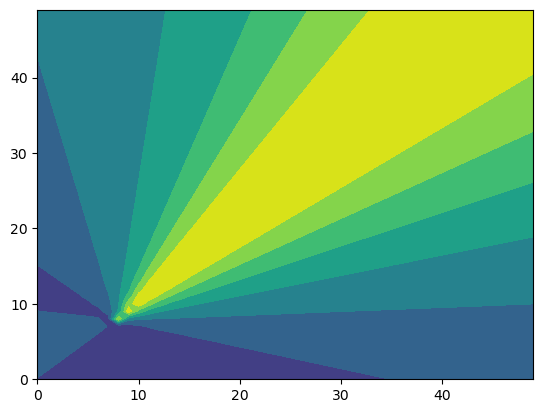

In [252]:
plt.contourf(Temperature)

In [1]:
Temperature[300,300]

NameError: name 'Temperature' is not defined